In [ ]:
#nltk.download('rslp')

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, file read (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline

#to data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#NLP tools
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

#train split and fit models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import TweetTokenizer

#model selection
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ragnarok09/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset = pd.read_csv('hate_speech_train.csv')
dataset.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,1,2,0,1,RT @HENNERGIZED: &#128557;&#128557;&#128557;&#...
1,3,0,3,0,1,We are back bitches! @vnpacheco21 @xoxoclaire_...
2,3,0,3,0,1,"RT @SuperrrrMcNasty: Lmfao , this bitch was gi..."
3,3,0,3,0,1,@bradley_eckman don't say shit like that lil n...
4,3,1,2,0,1,Young jezzy dat nigguh


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19826 entries, 0 to 19825
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               19826 non-null  int64 
 1   hate_speech         19826 non-null  int64 
 2   offensive_language  19826 non-null  int64 
 3   neither             19826 non-null  int64 
 4   class               19826 non-null  int64 
 5   tweet               19826 non-null  object
dtypes: int64(5), object(1)
memory usage: 929.5+ KB


In [4]:
dataset.describe()

,count,hate_speech,offensive_language,neither,class
count,19826.000000,19826.000000,19826.000000,19826.000000,19826.000000
mean,3.241350,0.282155,2.410370,0.548825,1.110663
std,0.876947,0.632042,1.396758,1.111109,0.462092
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


In [5]:
dataset_filtered = dataset[['class','tweet']]
y = (dataset_filtered.iloc[:,:-1].values).ravel()  #transforming a multi-dimensional array into a contiguous flattened array
dataset_filtered.head()

,class,tweet
0,1,RT @HENNERGIZED: &#128557;&#128557;&#128557;&#...
1,1,We are back bitches! @vnpacheco21 @xoxoclaire_...
2,1,"RT @SuperrrrMcNasty: Lmfao , this bitch was gi..."
3,1,@bradley_eckman don't say shit like that lil n...
4,1,Young jezzy dat nigguh


In [6]:
y[:10]

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1])

In [7]:
df_train, df_test = train_test_split(dataset_filtered, test_size = 0.10, random_state = 42, stratify=dataset_filtered['class'])
df_train.shape, df_test.shape

((17843, 2), (1983, 2))

<AxesSubplot:>

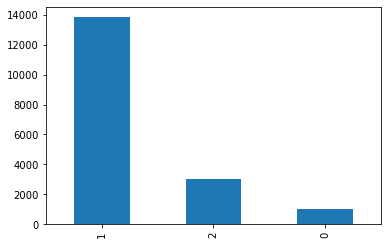

In [8]:
df_train['class'].value_counts().plot(kind='bar')

0 - Hate Speech <br>
1 - Offensive Language <br>
2 - Neither

**Cleaning the texts**

In [9]:
def preprocessing(data):
    stemmer = nltk.stem.RSLPStemmer()
    all_stopwords = stopwords.words('english')
    #all_stopwords.extend(['#ff', 'ff', 'rt'])
    all_stopwords.remove('not')
    #all_stopwords.remove('no')
    
    corpus = []
    for tweet in data:
        review = re.sub(r'@[A-Za-z0-9_]+', ' ', tweet)
        review = re.sub('RT', ' ', review)
        review = re.sub(r'https?://[A-Za-z0-9./]+', ' ', review)
        review = re.sub(r'https?', ' ', review)
        review = re.sub('[^a-zA-Z]', ' ', review)
        #review = re.sub('&#[0-9]*;',' ',review)
        #review = re.sub('&#[0-9]*',' ',review)
        review = review.lower()
        review = review.split()
        ps = PorterStemmer()
        review = [ps.stem(word) for word in review if not word in set(all_stopwords) if len(word) > 2]
        review = ' '.join(review)
        corpus.append(review)
        
    return np.array(corpus)

In [10]:
corpus = preprocessing(df_train['tweet'].values)
corpus.shape

(17843,)

In [11]:
corpus[:10]

array(['tank lot dare pube love uncl tom', 'messi ass hoe fuck friend',
       'use monkey maker prick', 'man birthday big booti bitch show love',
       'take girl back cheat littl bitch',
       'finna get leg dne amp hand catch hoe',
       'hangin corner late pocket straight bitch gon make rate dawg know sayin',
       'not yellow sorri', 'fuck pussi fuck mouth fuck ass caus nasti',
       'back inhighschool use stiff arm bitch kept tryna steal fit'],
      dtype='<U124')

In [12]:
c_train, c_vad, y_train, y_vad = train_test_split(corpus, df_train['class'], test_size = 0.10, random_state = 42, stratify=df_train['class'])
c_train.shape, c_vad.shape

((16058,), (1785,))

**Extracting features using tokenization**

In [13]:
def tokenize(c_train, c_vad):
    tweet_tokenizer = TweetTokenizer() 
    vectorizer = CountVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize, max_features = 1010)
    X_train = vectorizer.fit_transform(c_train).toarray()
    X_vad = vectorizer.transform(c_vad).toarray()
    return X_train, X_vad

In [14]:
X_train, X_vad = tokenize(c_train, c_vad)
X_train.shape, X_vad.shape

((16058, 1010), (1785, 1010))

**Logistic Regression**

In [15]:
model = LogisticRegression(multi_class='ovr', solver='liblinear', random_state = 0)
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_vad)

**Model Evaluation**

In [16]:
def set_confusion_matrix(clf, X, y, title):
    plot_confusion_matrix(clf, X, y)
    plt.title(title)
    plt.show()

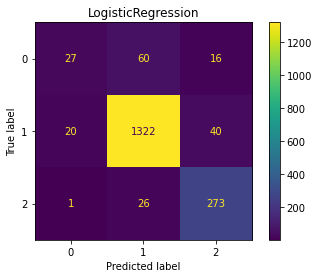

In [17]:
set_confusion_matrix(model, X_vad, y_vad, type(model).__name__)

In [18]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_vad, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.56      0.26      0.36       103
     class 1       0.94      0.96      0.95      1382
     class 2       0.83      0.91      0.87       300

    accuracy                           0.91      1785
   macro avg       0.78      0.71      0.72      1785
weighted avg       0.90      0.91      0.90      1785



**Looking better at the words of each class**

In [19]:
set_train = c_train
hate_tweets = [sentence for sentence, label in zip(set_train, y) if label == 0]
off_tweets = [sentence for sentence, label in zip(set_train, y) if label == 1]
none_tweets = [sentence for sentence, label in zip(set_train, y) if label == 2]

In [20]:
hate_words = ' '.join(hate_tweets)
off_words = ' '.join(off_tweets)
none_words = ' '.join(none_tweets)

In [21]:
def get_wordcloud(text):
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

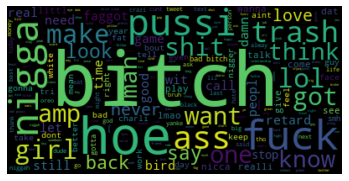

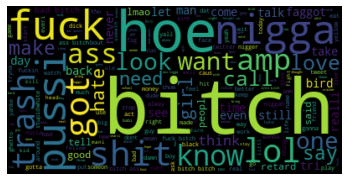

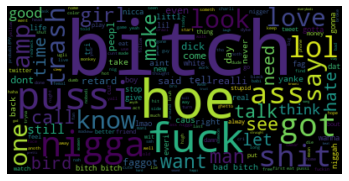

In [22]:
get_wordcloud(hate_words)
get_wordcloud(off_words)
get_wordcloud(none_words)

In [23]:
def wordListToFreqDict(wordlist):
    wordfreq = [(wordlist.count(p))/len(wordlist) for p in wordlist]
    return dict(list(zip(wordlist,wordfreq)))

In [24]:
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [25]:
hate_dict = sortFreqDict(wordListToFreqDict(hate_words.split()))
off_dict = sortFreqDict(wordListToFreqDict(off_words.split()))
none_dict = sortFreqDict(wordListToFreqDict(none_words.split()))

In [26]:
len(hate_dict), len(off_dict), len(none_dict)

(2259, 10492, 4412)

In [27]:
def get_common(wordlist, n):
    return ([w[1] for w in wordlist])[:n]

common_words = list()
common_words.append(get_common(hate_dict, 2000))
common_words.append(get_common(off_dict, 1000))
common_words.append(get_common(none_dict, 1000))
common_words = np.unique(np.hstack(common_words))

In [28]:
common_words_dict = ({i:j for i, j in zip(common_words, range(len(common_words)))})

In [29]:
tweet_tokenizer = TweetTokenizer() 
vectorizer = CountVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize, vocabulary=common_words_dict)
X_train = vectorizer.fit_transform(c_train).toarray()
X_vad = vectorizer.transform(c_vad).toarray()
X_train.shape, X_vad.shape

((16058, 2349), (1785, 2349))

In [30]:
# Logistic Regression
model = LogisticRegression(multi_class='ovr', solver='liblinear', random_state = 0)
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_vad)

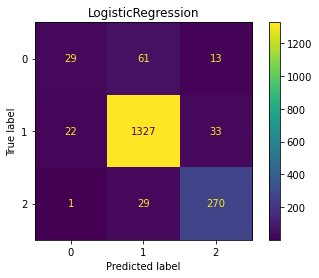

In [31]:
set_confusion_matrix(model, X_vad, y_vad, type(model).__name__)

In [32]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_vad, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.56      0.28      0.37       103
     class 1       0.94      0.96      0.95      1382
     class 2       0.85      0.90      0.88       300

    accuracy                           0.91      1785
   macro avg       0.78      0.71      0.73      1785
weighted avg       0.90      0.91      0.90      1785



**MAKING PREDICTIONS**

In [33]:
test_dataset = pd.read_excel('hate_speech_test.xlsx')
test_dataset.head()

,class,tweet
0,NaN,"RT @RedTvvitter: ""Does my Mewtwo make your pus..."
1,NaN,@kieffer_jason and who said I didn't like myse...
2,NaN,Get this bitch off my TV bruh
3,NaN,Lmfao bitch got her shit rocked
4,NaN,Verizon customer service is trash as fuck. I'v...


In [34]:
test_corpus = preprocessing(test_dataset['tweet'].values)
test_corpus.shape

(4957,)

In [35]:
test_corpus[:10]

array(['mewtwo make pussi wet',
       'said like fuck got shit made stfu stop assum bitch not ugli',
       'get bitch bruh', 'lmfao bitch got shit rock',
       'verizon custom servic trash fuck store greet noth',
       'gone broke wrong heart babi drove redneck crazi',
       'bitch ass arod shorti dont hit back',
       'clock hit clock imma need baddest lightest amp brightest hoe door give',
       'long beach california peopl automat think badass bitch hahha',
       'wick witch east done send vile bitch syria'], dtype='<U116')

In [36]:
X_test = vectorizer.transform(test_corpus).toarray()
X_test.shape

(4957, 2349)

In [37]:
y_test_pred = model.predict(X_test)
y_test_pred

array([1, 1, 1, ..., 2, 1, 0])

In [38]:
unique, counts = np.unique(y_test_pred, return_counts=True)
dict(zip(unique, counts))

{0: 155, 1: 3902, 2: 900}

In [39]:
test_dataset['class'] = y_test_pred
test_dataset.head(20)

,class,tweet
0,1,"RT @RedTvvitter: ""Does my Mewtwo make your pus..."
1,1,@kieffer_jason and who said I didn't like myse...
2,1,Get this bitch off my TV bruh
3,1,Lmfao bitch got her shit rocked
4,1,Verizon customer service is trash as fuck. I'v...
5,1,"you've gone and broke the wrong heart baby, an..."
6,1,bitch ass arod or shorty dont hit me back up
7,1,RT @T_ElMarauder: So when the clock hits 12 o'...
8,1,I'm from Long Beach California... so people au...
9,1,RT @gamma_ray239: The wicked witch of the east...


In [40]:
test_dataset.to_excel('Predictions_HateSpeech.xlsx')